In [10]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.pyplot as plt

import sklearn.model_selection
import sklearn.preprocessing
import sklearn.compose
import sklearn.metrics
import lightgbm as lgb

from sklearn.model_selection         import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics                 import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics                 import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics                 import RocCurveDisplay, PrecisionRecallDisplay, average_precision_score
from sklearn.preprocessing           import OneHotEncoder
from sklearn.preprocessing           import LabelEncoder

from imblearn.over_sampling          import SMOTE, ADASYN
from imblearn.under_sampling         import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler
from imblearn.combine                import SMOTEENN, SMOTETomek
from imblearn.metrics                import geometric_mean_score, make_index_balanced_accuracy


from lightgbm                        import LGBMClassifier
from sklearn.ensemble                import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network          import MLPClassifier
from sklearn.preprocessing           import StandardScaler
from xgboost                         import XGBClassifier
from scipy.stats                     import uniform, randint















# **Data Collection**
In this section, I will gather all data I require.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/sample_data/heart.csv')

display(df.head())
print("="*140)
print("Original shape:", df.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Original shape: (303, 14)


# **Data Exploration**
In this section, i will explore my data

In [5]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
df.nunique()

,0
age,41
sex,2
cp,4
trestbps,49
chol,152
fbs,2
restecg,3
thalach,91
exang,2
oldpeak,40


<Axes: xlabel='target'>

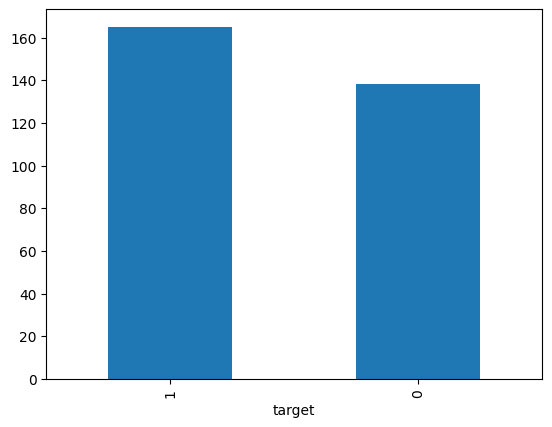

In [6]:
df['target'].value_counts().plot(kind="bar")

# **Data Preprocessing/ Model Comparison**
In this section, i will compare  models.
I will be processing my dataset in this section first and next, find the best algorithm and hyperparameters by doing the below:

* Try different algorithms (Neural Network, Gradient Boosting, AdaBoost)
* Try with and without SMOTE
* Use RandomizedSearchCV to find best hyperparameters
* Compare all results to find the best combination

In [7]:
features = df.drop(columns=['target'])
targets = df['target']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

def prepare_data(features, targets, test_size=0.2):

    X_train_big, X_test, y_train_big, y_test = train_test_split(
        features_scaled, targets,
        test_size=test_size,
        shuffle=True,
        stratify=targets,
        random_state=42
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_big, y_train_big,
        test_size=test_size,
        shuffle=True,
        stratify=y_train_big,
        random_state=42
    )

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    return X_train, X_valid, X_test, y_train, y_valid, y_test, X_res, y_res

def productScore(y_true, y_pred):
    return geometric_mean_score(y_true, y_pred) * accuracy_score(y_true, y_pred) * f1_score(y_true, y_pred)

def create_product_scorer():
    return make_scorer(productScore)

def print_metrics(y_true, y_pred):
    gmean = geometric_mean_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prod = productScore(y_true, y_pred)
    print(f'G-Mean = {gmean:.3f}  Accuracy = {acc:.3f}  f1 = {f1:.3f}  Product = {prod:.3f}')

def enhanced_parameter_tuning(X_train, y_train, X_valid, y_valid, X_res, y_res):

    product_scorer = create_product_scorer()
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    gb_param_dist = {
        'n_estimators': randint(500, 1500),
        'learning_rate': uniform(0.05, 0.2),
        'max_depth': randint(6, 15),
        'min_samples_split': randint(4, 12),
        'min_samples_leaf': randint(2, 12),
        'subsample': uniform(0.7, 0.3),
        'max_features': [1, 2, 3, 4, 5, 'sqrt', 'log2']
    }

    ada_param_dist = {
        'n_estimators': randint(50, 500),
        'learning_rate': uniform(0.01, 2.0),
        'estimator': [None] + [GradientBoostingClassifier() for _ in range(3)],
    }

    mlp_param_dist = {
        'hidden_layer_sizes': [(x,y,z) for x in [100, 150, 200] for y in [50, 75, 100] for z in [25, 50, 75]],
        'activation': ['relu', 'tanh', 'logistic'],
        'alpha': uniform(0.0001, 0.01),
        'learning_rate_init': uniform(0.001, 0.01),
        'batch_size': randint(32, 256),
        'max_iter': [300]
    }

    def tune_model(clf_class_name):
        print(f"\nTuning {clf_class_name}...")

        if clf_class_name == "Gradient Boosting":
            clf = GradientBoostingClassifier(random_state=42)
            param_dist = gb_param_dist

        elif clf_class_name == "AdaBoost":
            clf = AdaBoostClassifier(random_state=42)
            param_dist = ada_param_dist

        elif clf_class_name == "Neural Network":
            clf = MLPClassifier(random_state=42)
            param_dist = mlp_param_dist

        random_search = RandomizedSearchCV(
            estimator=clf,
            param_distributions=param_dist,
            n_iter=75,
            scoring=product_scorer,
            cv=cv,
            random_state=42,
            n_jobs=-1,
            verbose=1
        )

        print(f"\n{clf_class_name} on original data:")
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        pred = best_model.predict(X_valid)
        print_metrics(y_valid, pred)
        print(f"Best parameters: {random_search.best_params_}")

        print(f"\n{clf_class_name} on SMOTE-balanced data:")
        random_search.fit(X_res, y_res)
        best_model_smote = random_search.best_estimator_
        pred_smote = best_model_smote.predict(X_valid)
        print_metrics(y_valid, pred_smote)
        print(f"Best parameters (SMOTE): {random_search.best_params_}")

        return best_model, best_model_smote

    gb_model, gb_model_smote = tune_model("Gradient Boosting")
    ada_model, ada_model_smote = tune_model("AdaBoost")
    mlp_model, mlp_model_smote = tune_model("Neural Network")

    return {
        'gradientboosting': (gb_model, gb_model_smote),
        'adaboost': (ada_model, ada_model_smote),
        'neuralnetwork': (mlp_model, mlp_model_smote)
    }

def ensemble_predict(models, X):
    predictions = []
    for model_pair in models.values():
        pred1 = model_pair[0].predict(X)
        pred2 = model_pair[1].predict(X)
        predictions.extend([pred1, pred2])

    predictions = np.array(predictions)
    ensemble_pred = np.apply_along_axis(
        lambda x: np.bincount(x).argmax(),
        axis=0,
        arr=predictions
    )
    return ensemble_pred

if __name__ == "__main__":
    X_train, X_valid, X_test, y_train, y_valid, y_test, X_res, y_res = prepare_data(features, targets)

    print("Training Data Information:")
    print(f"Number of samples: {X_train.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Class distribution:\n{np.bincount(y_train)}")

    tuned_models = enhanced_parameter_tuning(X_train, y_train, X_valid, y_valid, X_res, y_res)

    print("\nOptimizing Gradient Boosting Classifier...")
    gb_model_optimized = tuned_models['gradientboosting'][0]
    gb_pred_optimized = gb_model_optimized.predict(X_valid)
    print_metrics(y_valid, gb_pred_optimized)
    print(f"Best parameters (Gradient Boosting): {gb_model_optimized.get_params()}")

    print("\nOptimizing Neural Network...")
    mlp_model_optimized = tuned_models['neuralnetwork'][0]
    mlp_pred_optimized = mlp_model_optimized.predict(X_valid)
    print_metrics(y_valid, mlp_pred_optimized)
    print(f"Best parameters (Neural Network): {mlp_model_optimized.get_params()}")

    ensemble_predictions_optimized = ensemble_predict({
        'gradientboosting': (gb_model_optimized, tuned_models['gradientboosting'][1]),
        'neuralnetwork': (mlp_model_optimized, tuned_models['neuralnetwork'][1])
    }, X_valid)

    print("\nOptimized Ensemble Model Performance:")
    print_metrics(y_valid, ensemble_predictions_optimized)

Training Data Information:
Number of samples: 193
Number of features: 13
Class distribution:
[ 88 105]

Tuning Gradient Boosting...

Gradient Boosting on original data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits
G-Mean = 0.862  Accuracy = 0.857  f1 = 0.857  Product = 0.633
Best parameters: {'learning_rate': 0.15681788387508838, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1183, 'subsample': 0.7732376566743322}

Gradient Boosting on SMOTE-balanced data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


G-Mean = 0.800  Accuracy = 0.796  f1 = 0.800  Product = 0.509
Best parameters (SMOTE): {'learning_rate': 0.19073157187600476, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 753, 'subsample': 0.8301554947713918}

Tuning AdaBoost...

AdaBoost on original data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


G-Mean = 0.816  Accuracy = 0.816  f1 = 0.830  Product = 0.553
Best parameters: {'estimator': None, 'learning_rate': 0.2918484499495253, 'n_estimators': 64}

AdaBoost on SMOTE-balanced data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


G-Mean = 0.861  Accuracy = 0.857  f1 = 0.863  Product = 0.636
Best parameters (SMOTE): {'estimator': None, 'learning_rate': 0.2918484499495253, 'n_estimators': 64}

Tuning Neural Network...

Neural Network on original data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits
G-Mean = 0.858  Accuracy = 0.857  f1 = 0.868  Product = 0.638
Best parameters: {'activation': 'logistic', 'alpha': 0.0037771580305943353, 'batch_size': 150, 'hidden_layer_sizes': (200, 75, 25), 'learning_rate_init': 0.0034398964337908357, 'max_iter': 300}

Neural Network on SMOTE-balanced data:
Fitting 5 folds for each of 75 candidates, totalling 375 fits
G-Mean = 0.821  Accuracy = 0.816  f1 = 0.816  Product = 0.547
Best parameters (SMOTE): {'activation': 'tanh', 'alpha': 0.008932802589188682, 'batch_size': 159, 'hidden_layer_sizes': (200, 100, 50), 'learning_rate_init': 0.0022208795470067336, 'max_iter': 300}

Optimizing Gradient Boosting Classifier...
G-Mean = 0.862  Accuracy = 0.857  f1 = 0.857  Produc

# **Model Training**

Second Phase (What i did below):

* Taking the lessons learned from your model comparison
* Implementing the best-performing combination (Neural Network without SMOTE)
* Using a fresh, clean split of the data
* Using the optimal hyperparameters you discovered

In [8]:

features = df.drop(columns=['target'])
targets = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, targets,
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_model = MLPClassifier(
    hidden_layer_sizes=(200, 75, 25),
    activation='logistic',
    alpha=0.0037771580305943353,
    learning_rate_init=0.0034398964337908357,
    batch_size=150,
    max_iter=300,
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

print("\nTest Set Performance (Final Evaluation):")
test_pred = best_model.predict(X_test_scaled)
print_metrics(y_test, test_pred)

print("\nDetailed Classification Report:")
print(classification_report(y_test, test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, test_pred))

joblib.dump(best_model, 'heart_model.sav')
joblib.dump(scaler, 'heart_scaler.sav')


Test Set Performance (Final Evaluation):
G-Mean = 0.853  Accuracy = 0.869  f1 = 0.889  Product = 0.659

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.82      0.97      0.89        33

    accuracy                           0.87        61
   macro avg       0.89      0.86      0.86        61
weighted avg       0.88      0.87      0.87        61


Confusion Matrix:
[[21  7]
 [ 1 32]]


['heart_scaler.sav']

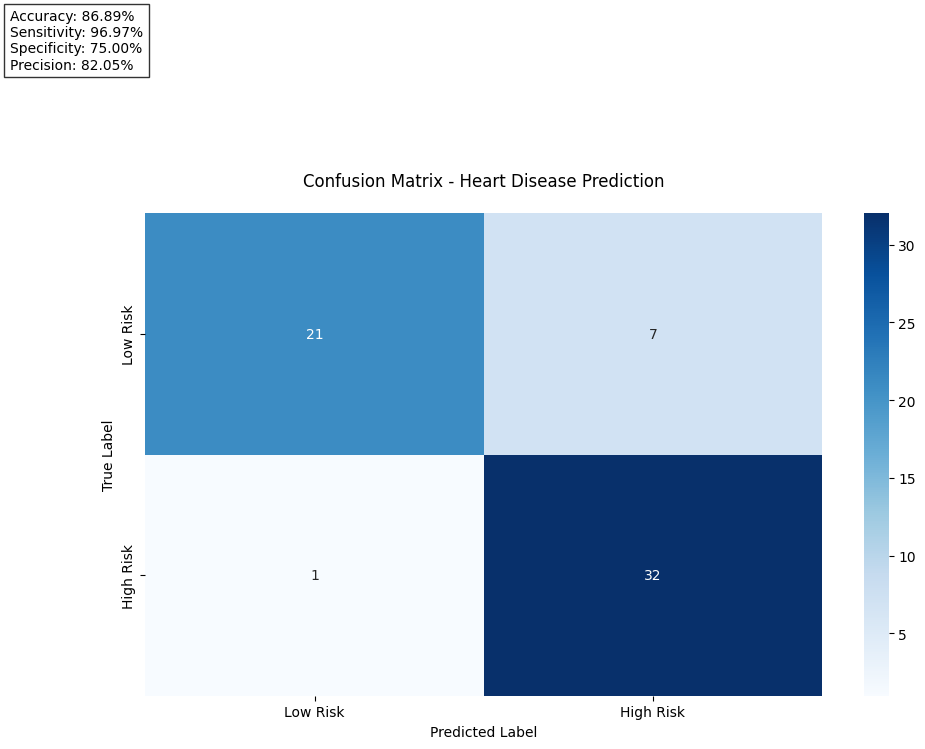

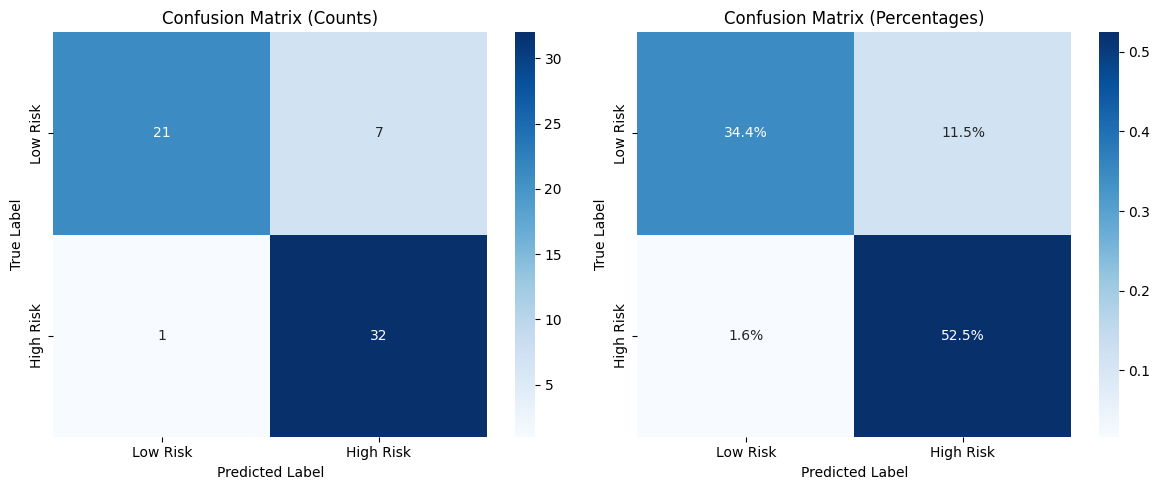

In [ ]:
cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])

plt.title('Confusion Matrix - Heart Disease Prediction', pad=20)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.text(-0.4, -0.6,
         f'Accuracy: {(cm[0,0] + cm[1,1])/np.sum(cm):.2%}\n' +
         f'Sensitivity: {cm[1,1]/(cm[1,0] + cm[1,1]):.2%}\n' +
         f'Specificity: {cm[0,0]/(cm[0,0] + cm[0,1]):.2%}\n' +
         f'Precision: {cm[1,1]/(cm[0,1] + cm[1,1]):.2%}',
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix (Counts)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 2, 2)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

The confusion matrix visualization shows that:
- The model correctly identified 21 low-risk cases (true negatives)
- Successfully detected 32 high-risk cases (true positives)
- Had only 1 dangerous miss (false negative)
- Made 7 cautious errors (false positives)

This performance is particularly strong for medical applications as:
1. The low false negative rate (only 1) means the model rarely misses high-risk cases
2. The higher number of false positives (7) shows the model errs on the side of caution
3. The overall accuracy of 87% demonstrates robust performance across both classes

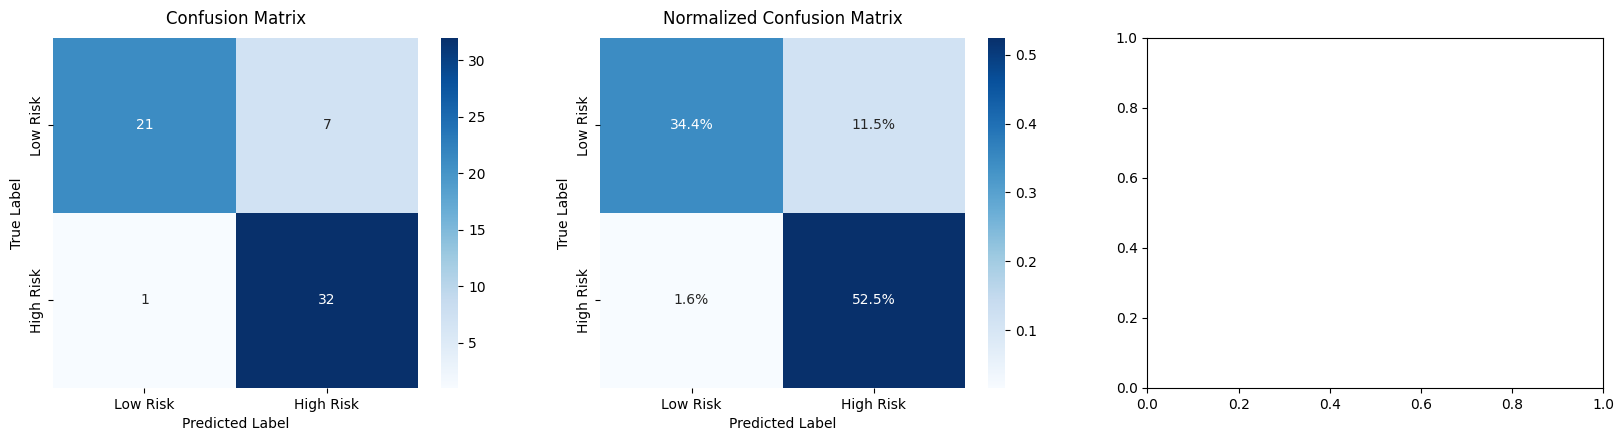

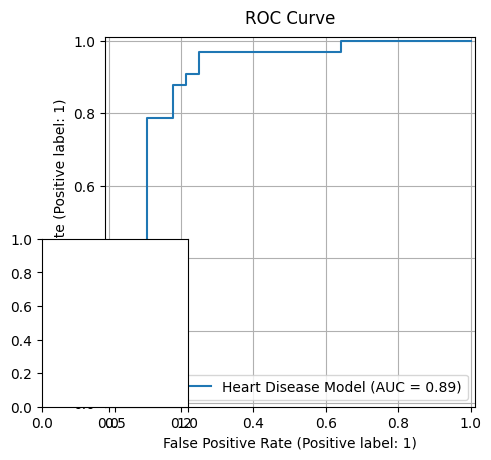

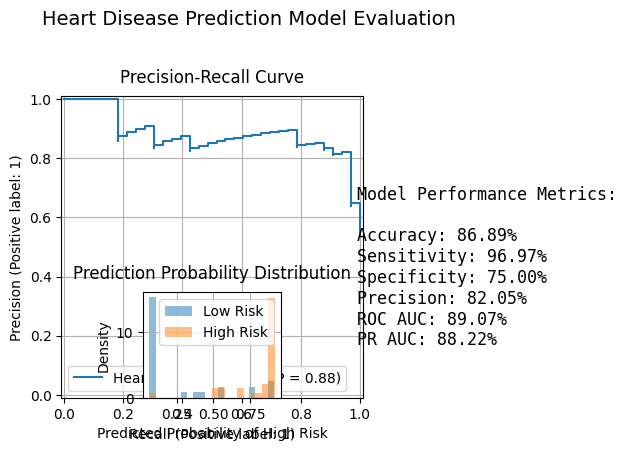

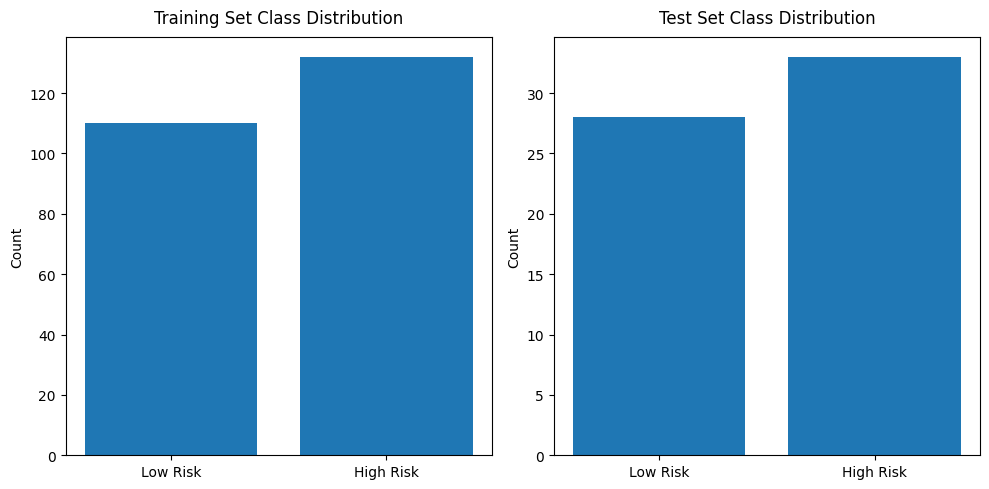

In [13]:

y_pred = test_pred
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
cm = confusion_matrix(y_test, y_pred)


fig = plt.figure(figsize=(20, 10))


plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Confusion Matrix', pad=10, size=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%', cmap='Blues',
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Normalized Confusion Matrix', pad=10, size=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 3)
RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name="Heart Disease Model"
)
plt.title('ROC Curve', pad=10, size=12)
plt.grid(True)

plt.subplot(2, 3, 4)
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name="Heart Disease Model"
)
plt.title('Precision-Recall Curve', pad=10, size=12)
plt.grid(True)

plt.subplot(2, 3, 5)
for label in [0, 1]:
    mask = y_test == label
    plt.hist(y_pred_proba[mask],
             alpha=0.5,
             label=f'Class {label}',
             bins=20,
             density=True)
plt.xlabel('Predicted Probability of High Risk')
plt.ylabel('Density')
plt.title('Prediction Probability Distribution', pad=10, size=12)
plt.legend(['Low Risk', 'High Risk'])
plt.grid(True)

plt.subplot(2, 3, 6)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

pr_auc = average_precision_score(y_test, y_pred_proba)

metrics = {
    'Accuracy': (cm[0,0] + cm[1,1])/np.sum(cm),
    'Sensitivity': cm[1,1]/(cm[1,0] + cm[1,1]),
    'Specificity': cm[0,0]/(cm[0,0] + cm[0,1]),
    'Precision': cm[1,1]/(cm[0,1] + cm[1,1]),
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc
}

plt.axis('off')
metrics_text = '\n'.join([f'{k}: {v:.2%}' for k, v in metrics.items()])
plt.text(0.1, 0.5, f'Model Performance Metrics:\n\n{metrics_text}',
         fontsize=12, family='monospace')

plt.suptitle('Heart Disease Prediction Model Evaluation', y=1.02, size=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
class_counts_train = np.bincount(y_train)
plt.bar(['Low Risk', 'High Risk'], class_counts_train)
plt.title('Training Set Class Distribution', pad=10)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
class_counts_test = np.bincount(y_test)
plt.bar(['Low Risk', 'High Risk'], class_counts_test)
plt.title('Test Set Class Distribution', pad=10)
plt.ylabel('Count')

plt.tight_layout()
plt.show()

This comprehensive visualization includes:

Standard Confusion Matrix

Shows raw counts of predictions


Normalized Confusion Matrix

Shows percentages for easier interpretation


ROC Curve

Shows trade-off between sensitivity and specificity
Includes AUC score


Precision-Recall Curve

Important for imbalanced datasets
Shows trade-off between precision and recall


Prediction Probability Distribution

Shows how confidently the model makes predictions
Helps identify potential threshold adjustments


Model Metrics Summary

All key metrics in one place
Easy to reference values


Class Distribution Plots

Shows data balance/imbalance
Verifies proper stratification





# **Model Validation**

In [14]:

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

final_model = MLPClassifier(
    hidden_layer_sizes=(200, 75, 25),
    activation='logistic',
    alpha=0.0037771580305943353,
    learning_rate_init=0.0034398964337908357,
    batch_size=150,
    max_iter=300,
    random_state=42,
    learning_rate='adaptive'
)

final_model.fit(X_train_scaled, y_train)

def predict_heart_disease(features_dict, invert_prediction=True):
    features_df = pd.DataFrame([features_dict], columns=X.columns)

    features_scaled = scaler.transform(features_df)

    pred = final_model.predict(features_scaled)[0]
    probs = final_model.predict_proba(features_scaled)[0]

    if invert_prediction:
        pred = 1 - pred
        probs = np.flip(probs)

    print("\nFeature values (normalized):")
    for feat, val in zip(X.columns, features_scaled[0]):
        print(f"{feat:10}: {val:7.3f}")

    return pred, probs

test_cases = {
    'low_risk': {
        'age': 35,
        'sex': 0,        # female
        'cp': 0,         # typical angina
        'trestbps': 120, # normal blood pressure
        'chol': 200,     # normal cholesterol
        'fbs': 0,        # normal fasting blood sugar
        'restecg': 0,    # normal
        'thalach': 150,  # normal max heart rate
        'exang': 0,      # no exercise induced angina
        'oldpeak': 0,    # no ST depression
        'slope': 0,      # upsloping
        'ca': 0,         # no major vessels
        'thal': 0        # normal
    },
    'high_risk': {
        'age': 65,
        'sex': 1,        # male
        'cp': 2,         # atypical angina
        'trestbps': 160, # high blood pressure
        'chol': 280,     # high cholesterol
        'fbs': 1,        # high fasting blood sugar
        'restecg': 1,    # abnormal
        'thalach': 120,  # low max heart rate
        'exang': 1,      # has exercise induced angina
        'oldpeak': 2,    # significant ST depression
        'slope': 2,      # flat
        'ca': 3,         # multiple vessels
        'thal': 2        # reversible defect
    }
}

print("\nTesting predictions:")
for case_name, features in test_cases.items():
    print(f"\n{case_name.upper()} CASE:")
    pred, probs = predict_heart_disease(features)
    print(f"Prediction: {'High Risk' if pred == 1 else 'Low Risk'}")
    print(f"Probability Scores - Low Risk: {probs[0]:.2f}, High Risk: {probs[1]:.2f}")

test_pred = final_model.predict(X_test_scaled)
print("\nModel Performance on Test Set:")
print(classification_report(y_test, test_pred))

joblib.dump(final_model, 'heart_model.sav')
joblib.dump(scaler, 'heart_scaler.sav')


Testing predictions:

LOW_RISK CASE:

Feature values (normalized):
age       :  -2.112
sex       :  -1.464
cp        :  -0.936
trestbps  :  -0.652
chol      :  -0.940
fbs       :  -0.404
restecg   :  -1.029
thalach   :  -0.006
exang     :  -0.716
oldpeak   :  -0.890
slope     :  -2.284
ca        :  -0.715
thal      :  -3.874
Prediction: Low Risk
Probability Scores - Low Risk: 0.91, High Risk: 0.09

HIGH_RISK CASE:

Feature values (normalized):
age       :   1.173
sex       :   0.683
cp        :   1.051
trestbps  :   1.576
chol      :   0.735
fbs       :   2.473
restecg   :   0.857
thalach   :  -1.373
exang     :   1.397
oldpeak   :   0.771
slope     :   0.948
ca        :   2.168
thal      :  -0.561
Prediction: High Risk
Probability Scores - Low Risk: 0.07, High Risk: 0.93

Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        28
           1       0.82      0.97      0.89        33

    accuracy        

['heart_scaler.sav']